In [187]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from scipy.ndimage import gaussian_filter1d

##### Globals

Note that this code is written for plotttin gmultiple agent in the same plot. However, since differrent agents exhibit different cl setups based on their training performance, this is not logial to do plot with the current setup

In [188]:
from train3d import scenarios 
scenarios = list(scenarios.keys())
metrics_paths = ["2_terminal_metrics/collision_rate", 
                 "2_terminal_metrics/success_rate",
                 "3_metrics/a_avg_path_progression",
                 "3_metrics/ep_&_a_avg_total_path_deviance",
                 "4_quadcopter_state/ep_&_a_avg_speed"] 
metrics_plotting_names = ["Collision Rate", "Success Rate", "Path Progression", "Average Path Deviance [m]", "Average Speed [m/s]"]
label_plotting_names = ["Collision Rate", "Success Rate", "Path Progression", "Average Path Deviance", "Average Speed"]
exp_ids = [32]
agents_for_exp = ["testagent1"] #TODO FILL    
# create dict with expid as key corresponding item from agents_for_exp as value
exp_agents = dict(zip(exp_ids, agents_for_exp))
print(exp_agents)

{32: 'testagent1'}


##### Load data from TensorBoard

In [189]:
exp_id_to_dfs = {}

for exp_id in exp_ids:
    dfs = {}

    for metric in metrics_paths:
        df = pd.DataFrame()
        prev_scen_final_timestep = 0
        for scenario in scenarios:
            # Extract tf events from logs for given scenario-metric combo
            log_dir = f"log/LV_VAE_MESH-v0/Experiment {exp_id}/{scenario}/tensorboard/PPO_0/"

            event_accumulator = EventAccumulator(log_dir)
            event_accumulator.Reload()

            events = event_accumulator.Scalars(metric)
            x = [x.step for x in events]
            y = [x.value for x in events]
            
            metric_name = metric.split("/")[-1]
            df_scen = pd.DataFrame({"scenario": scenario, "timestep": x, f"{metric_name}": y})

            # Order by timestep and remove instances with overlapping timesteps, this can happen if training run has been obstructed
            df_scen = df_scen.sort_values("timestep")
            df_scen = df_scen.drop_duplicates(subset="timestep", keep="last")

            # NB timesteps are ordered correctly and no not begin at 0 for each secenario!
            
            # set prev_scen_final_timestep to the final timestep of the current scenario
            if prev_scen_final_timestep > df_scen["timestep"].iloc[0]:
                # Rremove instance
                print(f"Removing overlapping timesteps in scenario {scenario}")
                df_scen = df_scen[df_scen["timestep"] > prev_scen_final_timestep]

            prev_scen_final_timestep = df_scen["timestep"].iloc[-1]
            # Append to the main dataframe
            df = pd.concat([df, df_scen])
        
        dfs[metric_name] = df

        # ensure that timesteps is increasing
        for i in range(1, len(df)):
            if not df["timestep"].iloc[i] > df["timestep"].iloc[i-1]:
                print(f"Error at index {i} in metric: {metric_name}")
                print(df.iloc[i-1:i+1])

    exp_id_to_dfs[exp_id] = dfs
    print("Done loading data for experiment", exp_id)

Removing overlapping timesteps in scenario expert
Removing overlapping timesteps in scenario expert
Removing overlapping timesteps in scenario expert
Removing overlapping timesteps in scenario expert
Removing overlapping timesteps in scenario expert
Done loading data for experiment 32


##### Plot

In [190]:
plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)

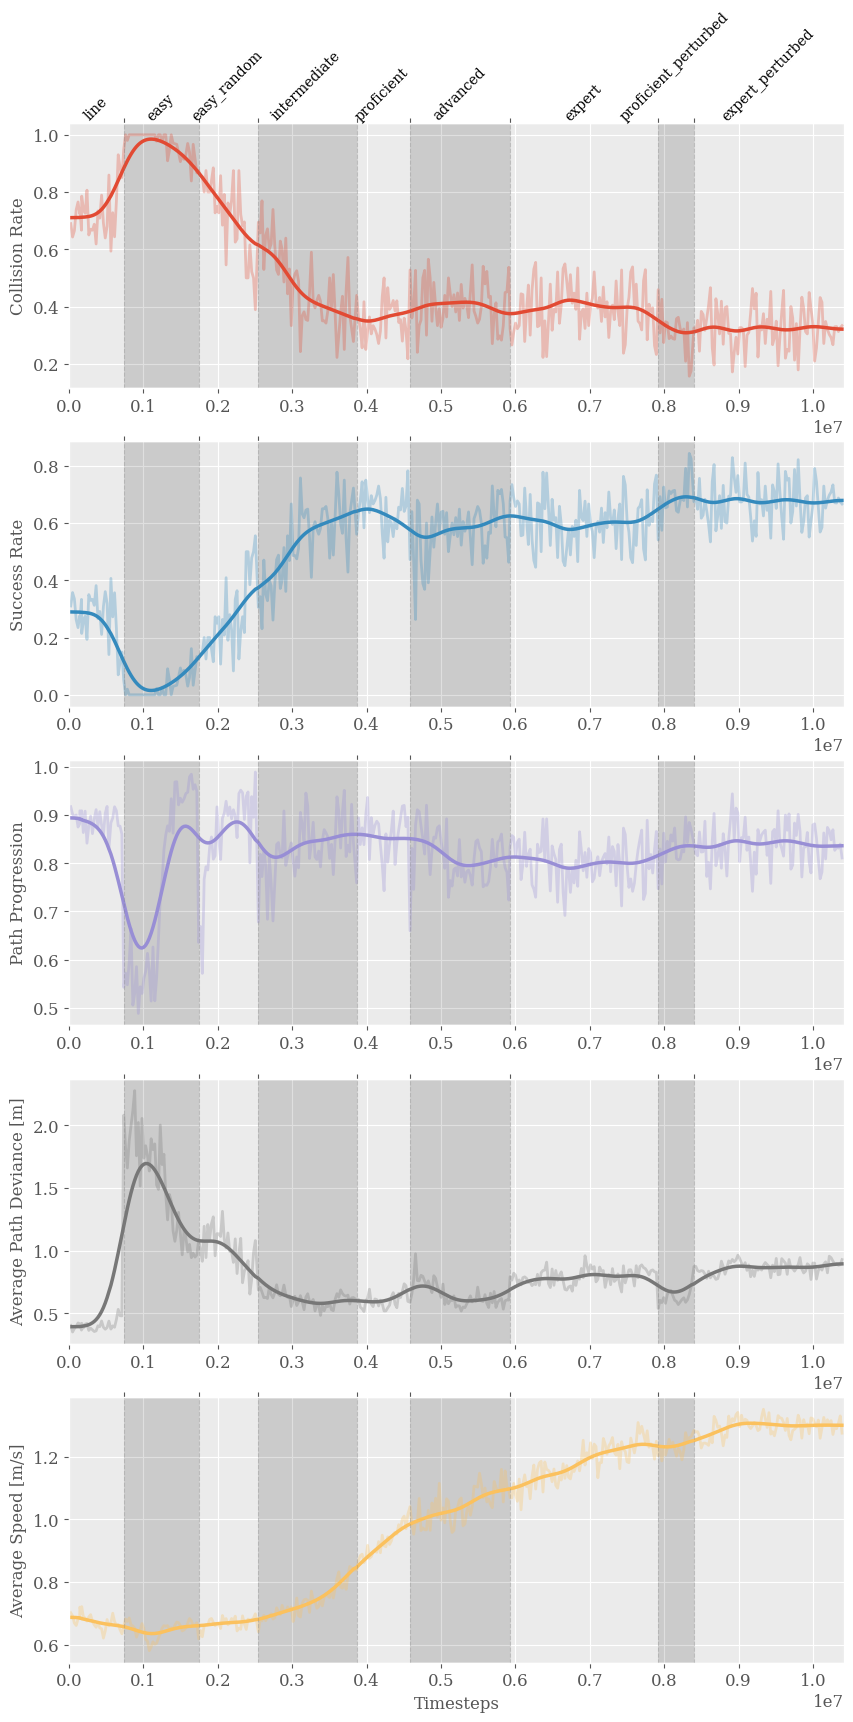

In [191]:
# Initialize color cycler only once per experiment id
    
n_metrics = len(metrics_paths)
fig, ax = plt.subplots(n_metrics, 1, figsize=(10, 20))
for j, (metric_name, data) in enumerate(dfs.items()):
    current_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_j = current_cycler[j]
    lower_bound = min(data[metric_name])
    upper_bound = max(data[metric_name])

    # Smooth values if needed
    values_smooth = gaussian_filter1d(data[metric_name], sigma=8)

    ax[j].plot(data["timestep"], data[metric_name], color=color_j, alpha=0.3, zorder=5, linewidth=2.0)
    ax[j].plot(data["timestep"], values_smooth, color=color_j, zorder=10, linewidth=2.5)

    # Shade plot
    #if j == 0:
        #l = ax[j].legend(loc='upper left', fontsize=10, framealpha=1.0, fancybox=True)
        #l.set_zorder(3)
    ylow_fill, yhigh_fill = ax[j].get_ybound()

    for k, scenario in enumerate(scenarios):
        scenario_data = data[data["scenario"] == scenario]
        next_scenario_data = data[data["scenario"] == scenarios[k + 1]] if k + 1 < len(scenarios) else None
        last_index_for_fill = scenario_data["timestep"].iloc[-1] if next_scenario_data is None else next_scenario_data["timestep"].iloc[0]
        color = "white" if k % 2 == 0 else "gray"
        ax[j].fill_between([scenario_data["timestep"].iloc[0], last_index_for_fill], ylow_fill, yhigh_fill, color=color, alpha=0.25, zorder=1)
    
    ax[j].set_xlabel("Timesteps") if j == n_metrics - 1 else ax[j].set_xlabel("")
    ax[j].set_ylabel(metrics_plotting_names[j])
    ax[j].set_xlim(0, data["timestep"].iloc[-1] + data["timestep"].iloc[0])
    ax[j].set_ylim(ylow_fill, yhigh_fill)

    # Add upper axis with scenario names if first plot and only ticks else
    
    scenario_text_positions_x = []
    upper_ax_ticks = []
    for scenario in scenarios:
        scenario_data = data[data["scenario"] == scenario]
        midpoint = (scenario_data["timestep"].iloc[0] + scenario_data["timestep"].iloc[-1]) // 2
        scenario_text_positions_x.append(midpoint)
        upper_ax_ticks.append(scenario_data["timestep"].iloc[0])

    upper_ax_ticks = upper_ax_ticks[1:]  # Remove first tick
    ax_upper = ax[j].twiny()
    ax_upper.set_xlim(0, data["timestep"].iloc[-1])
    ax_upper.set_xticks(upper_ax_ticks)
    ax_upper.grid(True, which='both', linestyle='--', linewidth=0.8, color='gray', alpha=0.3, zorder=2)
    ax_upper.set_xticklabels([' ' for _ in range(len(scenarios) - 1)])

    if j == 0:
        # Add the scenario names
        y_lim = ax[j].get_ylim()[1]
        pad_y_text = 0.01
        for k, scenario in enumerate(scenarios):
            ax_upper.text(scenario_text_positions_x[k], y_lim + pad_y_text, scenario, ha='center', va='baseline', rotation=45, transform=ax_upper.transData, fontsize=10)
        
    # Align axes
    ax_upper.set_xbound(ax[j].get_xbound())

    # Increase number of ticks on x-axis to make it more readable
    ax[j].xaxis.set_major_locator(plt.MaxNLocator(11))

    # If final plot add label below x axis describing the colors
    legend_elements = [Line2D([0], [0], color=c, lw=2.0, label=label) for c, label in zip(current_cycler[:len(label_plotting_names)], label_plotting_names)]
    #if j == n_metrics - 1:
        #ax[j].legend(handles=legend_elements, bbox_to_anchor=(0.0, -0.5, 0, 0), loc="lower left", fontsize=12, framealpha=1.0, fancybox=True, ncol=3)
    plt.savefig("baseline_agent.pdf", bbox_inches='tight')
        #plt.close(fig) 